In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import pickle
from ethnicseer import EthnicClassifier

In [2]:
def calculate_stats(results_test, results_pred, name, display_labels):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    if len(display_labels) > 2:
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred, average='weighted')
        recall = recall_score(results_test, results_pred, average='weighted')
        f1 = f1_score(results_test, results_pred, average='weighted')
    else:
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred, pos_label='ind')
        recall = recall_score(results_test, results_pred, pos_label='ind')
        f1 = f1_score(results_test, results_pred, pos_label='ind')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)


In [3]:
def visualize_embeddings(X, y, names=None, n_samples=1000, method='tsne'):
    
    if len(X) > n_samples:
        idx = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[idx]
        y_sample = y[idx]
        if names is not None:
            names_sample = [names[i] for i in idx]
        else:
            names_sample = None
    else:
        X_sample = X
        y_sample = y
    
    if method == 'tsne':
        # Use t-SNE for dimensionality reduction
        reducer = TSNE(n_components=3, random_state=42)
    else:
        # Use PCA as fallback
        reducer = PCA(n_components=3)
    
    embeddings = reducer.fit_transform(X_sample)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_classes = np.unique(y_sample)
    colors = sns.color_palette("husl", len(unique_classes))
    
    for i, cls in enumerate(unique_classes):
        mask = (y_sample == cls)
        ax.scatter(embeddings[mask, 0], embeddings[mask, 1], embeddings[mask, 2],
                   color=colors[i], label=cls, alpha=0.6)
    
    ax.set_title('3D Visualization of Name Embeddings')
    ax.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(unique_classes):
        mask = (y_sample == cls)
        plt.scatter(embeddings[mask, 0], embeddings[mask, 1],
                    color=colors[i], label=cls, alpha=0.6)
    
    plt.title('2D Visualization of Name Embeddings')
    plt.legend()
    plt.show()
    
    
    if names_sample is not None:
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
        
        # First plot the points
        for i, cls in enumerate(unique_classes):
            mask = (y_sample == cls)
            ax.scatter(embeddings[mask, 0], embeddings[mask, 1],
                        color=colors[i], label=cls, alpha=0.6)
        
        # Then add text labels
        for i, (x, y) in enumerate(zip(embeddings[:, 0], embeddings[:, 1])):
            ax.text(x, y, names_sample[i], fontsize=8, alpha=0.7,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5))
        
        plt.title('2D Visualization with Name Labels')
        plt.legend()
        plt.show()

In [4]:
def preprocess_name(name):
    parts = name.strip().split()
    first_name = parts[0].lower() if len(parts) > 0 else ""
    last_name = parts[-1].lower() if len(parts) > 1 else ""
    
    f4_first = first_name[:4] if len(first_name) >= 4 else first_name
    l4_first = first_name[-4:] if len(first_name) >= 4 else first_name
    f4_last = last_name[:4] if len(last_name) >= 4 else last_name
    l4_last = last_name[-4:] if len(last_name) >= 4 else last_name
    
    n_sub_names = len(parts)
    has_dash = any('-' in part for part in parts)
    
    return {
        'first_name': first_name,
        'last_name': last_name,
        'f4_first': f4_first,
        'l4_first': l4_first,
        'f4_last': f4_last,
        'l4_last': l4_last,
        'n_sub_names': min(n_sub_names, 4),
        'has_dash': int(has_dash)
    }


In [5]:
def build_name_stats(df, name_col='name', ethnicity_col='ethnic'):
    first_name_stats = defaultdict(lambda: defaultdict(int))
    last_name_stats = defaultdict(lambda: defaultdict(int))
    f4_first_stats = defaultdict(lambda: defaultdict(int))
    l4_first_stats = defaultdict(lambda: defaultdict(int))
    f4_last_stats = defaultdict(lambda: defaultdict(int))
    l4_last_stats = defaultdict(lambda: defaultdict(int))
    
    for _, row in df.iterrows():
        name_info = preprocess_name(row[name_col])
        ethnicity = row[ethnicity_col]
        
        first_name_stats[name_info['first_name']][ethnicity] += 1
        last_name_stats[name_info['last_name']][ethnicity] += 1
        f4_first_stats[name_info['f4_first']][ethnicity] += 1
        l4_first_stats[name_info['l4_first']][ethnicity] += 1
        f4_last_stats[name_info['f4_last']][ethnicity] += 1
        l4_last_stats[name_info['l4_last']][ethnicity] += 1
    
    return {
        'first_name_stats': first_name_stats,
        'last_name_stats': last_name_stats,
        'f4_first_stats': f4_first_stats,
        'l4_first_stats': l4_first_stats,
        'f4_last_stats': f4_last_stats,
        'l4_last_stats': l4_last_stats
    }


In [6]:
def create_features(name, stats, cats=['ind', 'not']):
    name_info = preprocess_name(name)
    features = {}
    
    for eth in cats:
        fn_counts = stats['first_name_stats'][name_info['first_name']]
        total_fn = sum(fn_counts.values())
        features[f'probability_{eth}_first_name'] = fn_counts.get(eth, 0) / (total_fn + 1)
        
        ln_counts = stats['last_name_stats'][name_info['last_name']]
        total_ln = sum(ln_counts.values())
        features[f'probability_{eth}_last_name'] = ln_counts.get(eth, 0) / (total_ln + 1)
        
        f4f_counts = stats['f4_first_stats'][name_info['f4_first']]
        total_f4f = sum(f4f_counts.values())
        features[f'probability_{eth}_first_name_f4'] = f4f_counts.get(eth, 0) / (total_f4f + 1)
        
        l4f_counts = stats['l4_first_stats'][name_info['l4_first']]
        total_l4f = sum(l4f_counts.values())
        features[f'probability_{eth}_first_name_l4'] = l4f_counts.get(eth, 0) / (total_l4f + 1)
        
        f4l_counts = stats['f4_last_stats'][name_info['f4_last']]
        total_f4l = sum(f4l_counts.values())
        features[f'probability_{eth}_last_name_f4'] = f4l_counts.get(eth, 0) / (total_f4l + 1)
        
        l4l_counts = stats['l4_last_stats'][name_info['l4_last']]
        total_l4l = sum(l4l_counts.values())
        features[f'probability_{eth}_last_name_l4'] = l4l_counts.get(eth, 0) / (total_l4l + 1)
        
        features[f'best_evidence_{eth}'] = max(
            features[f'probability_{eth}_first_name'],
            features[f'probability_{eth}_last_name']
        )
    
    features['dash_indicator'] = name_info['has_dash']
    features['n_sub_names'] = name_info['n_sub_names']
    
    return features


In [7]:
def is_indistinguishable(name, stats, threshold=0.15):
    
    name_info = preprocess_name(name)
    features = create_features(name, stats)
    
    cats = sorted(stats['first_name_stats'][name_info['first_name']].keys())
    psi = {cat: features[f'probability_{cat}_first_name'] for cat in cats}
    phi = {cat: features[f'probability_{cat}_last_name'] for cat in cats}
    
    indistinguishable_pairs = []
    
    for i, r1 in enumerate(cats):
        for r2 in cats[i+1:]:
            
            condition1 = (abs(psi[r1] - psi[r2]) <= threshold and 
                         abs(phi[r1] - phi[r2]) <= threshold)
            
            max_psi = max(psi.values())
            max_phi = max(phi.values())
            condition2 = (max_psi - min(psi[r1], psi[r2]) <= threshold and 
                         max_phi - min(phi[r1], phi[r2]) <= threshold)
            
            if condition1 and condition2:
                indistinguishable_pairs.append(f"{r1}-{r2}")
    
    return indistinguishable_pairs if indistinguishable_pairs else None


In [8]:
def handle_indistinguishables(df, stats, name_col='name'):
    
    df['indistinguishable'] = None
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        name = row[name_col]
        indistinguishable = is_indistinguishable(name, stats)
        
        if indistinguishable:
            df.at[idx, 'indistinguishable'] = ','.join(indistinguishable)
    
    return df


In [9]:
def process_data(df, name_col='name', ethnicity_col='ethnic', train_size=100000):
    
    stats = build_name_stats(df, name_col, ethnicity_col)
    
    class_counts = df[ethnicity_col].value_counts()
    class_weights = {class_counts.index[i]: sum(class_counts)/count for i, count in enumerate(class_counts)}
    
    X, y = [], []
    for _, row in tqdm(df.iterrows()):
        features = create_features(row[name_col], stats)
        X.append(list(features.values()))
        y.append(row[ethnicity_col])
    
    X, y = np.array(X), np.array(y)
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    visualize_embeddings(X, y, list(df[name_col]))
    
    return X_train, X_test, y_train, y_test, class_weights
    

In [10]:
def name_classifier(df, X_train, X_test, y_train, y_test, class_weights, name_col='name', ethnicity_col='ethnic'):
    
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight=class_weights
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    cats = sorted(df[ethnicity_col].unique())
    
    calculate_stats(y_test, y_pred, "Name Classifier", cats)
    
    return model


In [11]:
df = pd.read_csv("./data/wiki_name_race.csv")
df["ethnic"] = df["race"].apply(lambda x: x.split(",")[-1])
df["name"] = df['name_first'].str.cat(df[['name_middle', 'name_last', 'name_suffix']], sep=' ', na_rep='')
df

,name_last,name_suffix,name_first,name_middle,race,ethnic,name
0,heynis,NaN,aafje,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,aafje heynis
1,noordewier-reddingius,NaN,aaltje,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,aaltje noordewier-reddingius
2,de quant,NaN,abbie,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,abbie de quant
3,NaN,NaN,abbo of provence,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,abbo of provence
4,ahanfouf,NaN,abdelaziz,NaN,"GreaterEuropean,WestEuropean,Germanic",Germanic,abdelaziz ahanfouf
...,...,...,...,...,...,...,...
148270,NaN,NaN,zoe,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zoe
148271,karbonopsina,NaN,zoe,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zoe karbonopsina
148272,mirkoviÄ,NaN,zoran,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zoran mirkoviÄ
148273,NaN,NaN,zotto,NaN,"GreaterEuropean,WestEuropean,Italian",Italian,zotto


In [12]:
df = df[["name", "ethnic"]]
df["ethnic"] = df["ethnic"].apply(lambda x: "ind" if x == "IndianSubContinent" else "not")
df = df.dropna()
df

C:\Users\karnav\AppData\Local\Temp\ipykernel_32692\784486912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ethnic"] = df["ethnic"].apply(lambda x: "ind" if x == "IndianSubContinent" else "not")


,name,ethnic
0,aafje heynis,not
1,aaltje noordewier-reddingius,not
2,abbie de quant,not
3,abbo of provence,not
4,abdelaziz ahanfouf,not
...,...,...
148270,zoe,not
148271,zoe karbonopsina,not
148272,zoran mirkoviÄ,not
148273,zotto,not


In [13]:
df["ethnic"].value_counts()

ethnic
not    139212
ind      9063
Name: count, dtype: int64

In [14]:
# https://github.com/philipperemy/name-dataset
df_indian = pd.read_csv("./data/IN.csv")
df_indian.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
df_indian['firstname'] = df_indian['firstname'].apply(lambda x: x.split(" ")[0] if " " in str(x) else str(x))
df_indian['lastname'] = df_indian['lastname'].apply(lambda x: x.split(" ")[-1] if " " in str(x) else str(x))
df_indian['name'] = df_indian['firstname'].apply(lambda x: x.lower()) + ' ' + df_indian['lastname'].apply(lambda x: x.lower())
df_indian["ethnic"] = df_indian["ethnicity"].apply(lambda x: "ind")
df_indian

,firstname,lastname,gender,ethnicity,name,ethnic
0,Kapil,Kumar,M,IN,kapil kumar,ind
1,Mitali,Aggarwal,F,IN,mitali aggarwal,ind
2,Vikas,Jangra,NaN,IN,vikas jangra,ind
3,Ravi,Lungay,M,IN,ravi lungay,ind
4,Jagat,Yadav,M,IN,jagat yadav,ind
...,...,...,...,...,...,...
6161585,Vikas,Chakchanpur,M,IN,vikas chakchanpur,ind
6161586,Dipu,Gupta,M,IN,dipu gupta,ind
6161587,Riya,Naharwal,F,IN,riya naharwal,ind
6161588,Jashandeep,Hanjra,M,IN,jashandeep hanjra,ind


In [15]:
df_us = pd.read_csv("./data/US.csv")
df_us.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
df_us['name'] = df_us['firstname'].apply(lambda x: str(x).lower()) + ' ' + df_us['lastname'].apply(lambda x: str(x).lower())
df_us["ethnic"] = df_us["ethnicity"].apply(lambda x: "not")
df_us

,firstname,lastname,gender,ethnicity,name,ethnic
0,Brandon,Sylvester,M,US,brandon sylvester,not
1,Chris,Toussaint,M,US,chris toussaint,not
2,Willie,Gotti,M,US,willie gotti,not
3,Cristobal,Corona,M,US,cristobal corona,not
4,Wilmer,Diaz,M,US,wilmer diaz,not
...,...,...,...,...,...,...
32308967,Albert,Hall,M,US,albert hall,not
32308968,Dede,Love,M,US,dede love,not
32308969,Kylie,Smith,F,US,kylie smith,not
32308970,Koy,Smith,M,US,koy smith,not


148275it [00:04, 36864.90it/s]
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python312\Lib\subproce

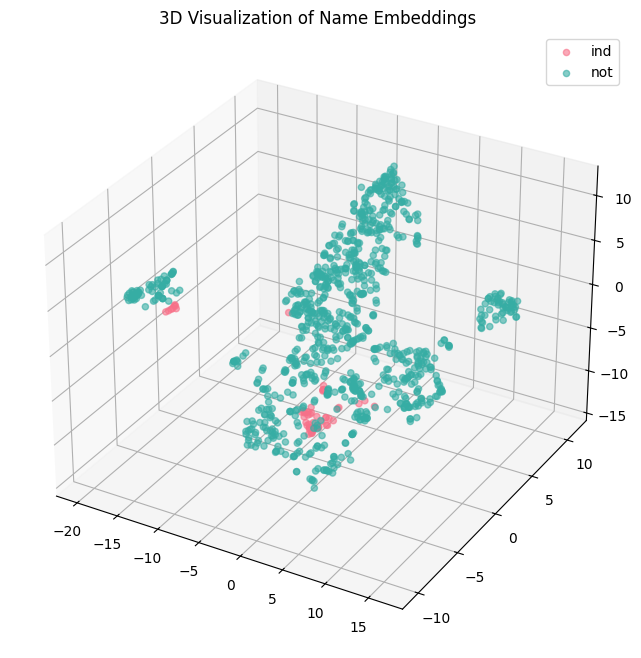

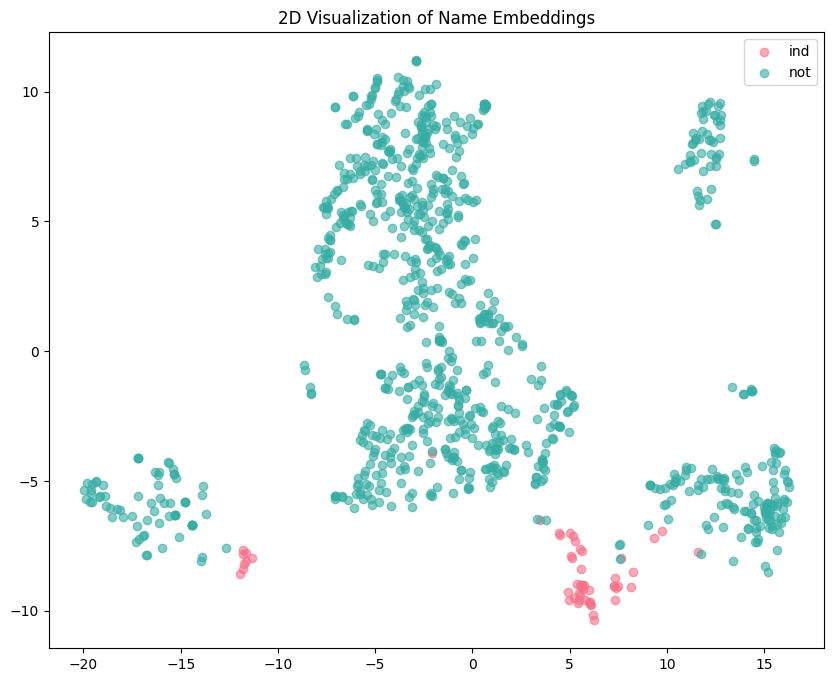

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 158 (\x9e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 159 (\x9f) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


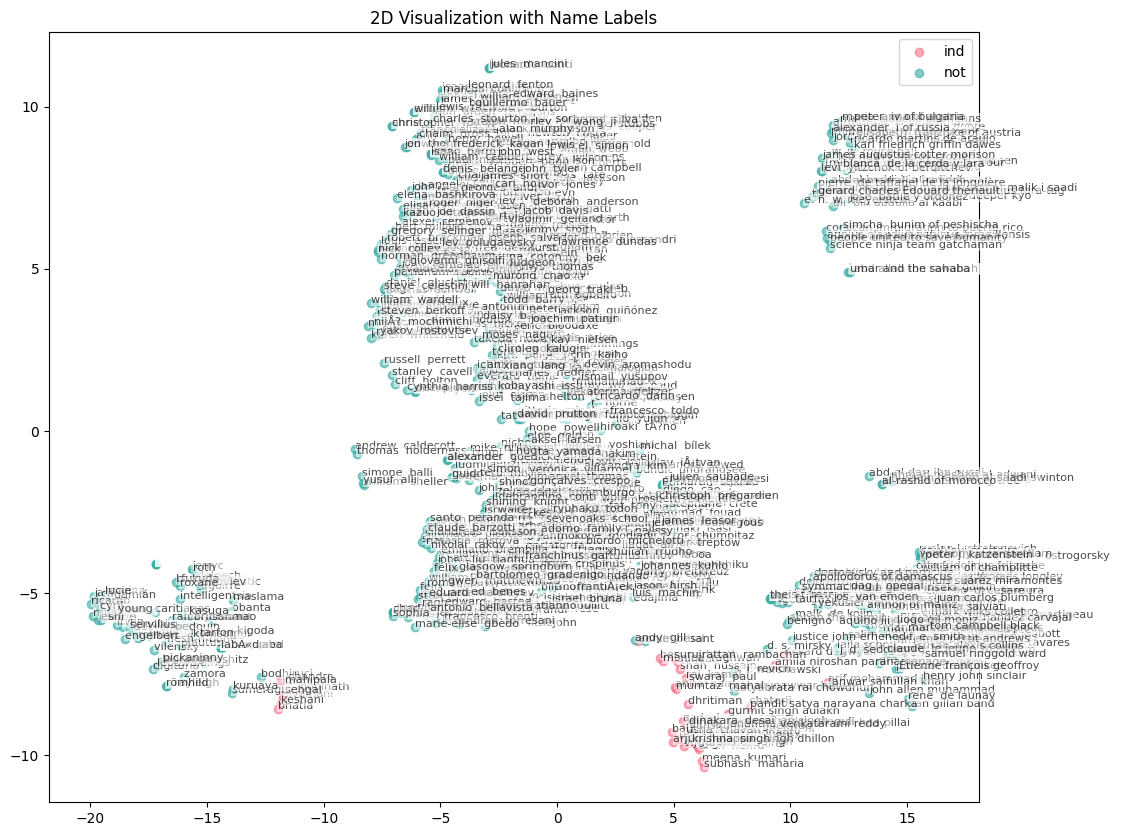

In [16]:
X_train, X_test, y_train, y_test, weights = process_data(df)

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


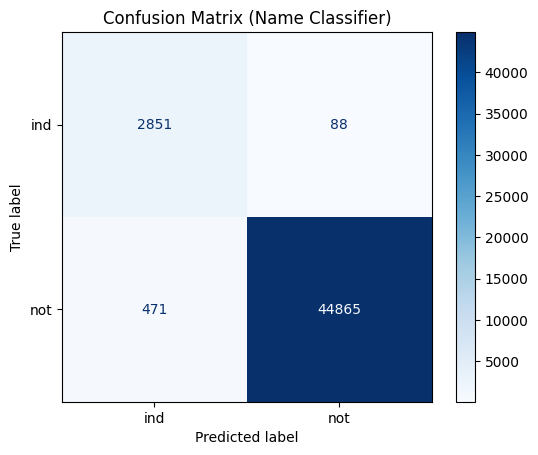


Name Classifier
Accuracy: 0.9884205075090626
Precision: 0.858217940999398
Recall: 0.9700578428036747
F1: 0.9107171378374062


In [17]:
model = name_classifier(df, X_train, X_test, y_train, y_test, weights)

In [18]:
y_probs = model.predict_proba(X_test)[:, 1]
y_probs

array([0.99835246, 0.99688323, 0.99955527, ..., 0.9454125 , 0.99113166,
       0.98731203])

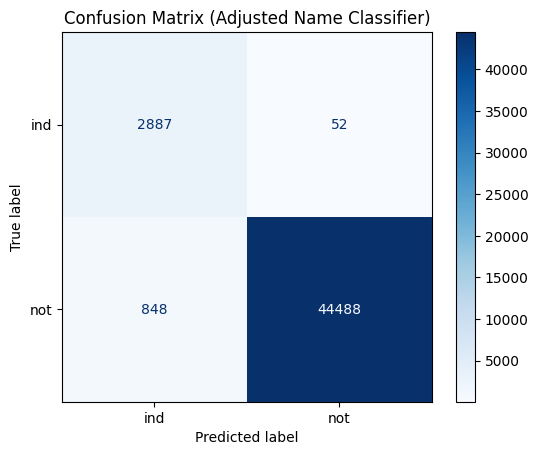


Adjusted Name Classifier
Accuracy: 0.9813568099430346
Precision: 0.772958500669344
Recall: 0.9823069071112623
F1: 0.8651483368294876


In [19]:
y_pred_adjusted = (y_probs <= 0.80).astype(int)
calculate_stats(y_test, np.where(y_pred_adjusted == 1, "ind", "not"), "Adjusted Name Classifier", sorted(df["ethnic"].unique()))

In [20]:
with open('./models/wiki_name_classifier.pkl', 'wb') as file:
    pickle.dump(model, file)

In [30]:
df_combined = pd.concat([df, df_indian[["name", "ethnic"]], df_us[["name", "ethnic"]]], ignore_index=True)
df_combined = df_combined.sample(5000000, random_state=42)
df_combined

,name,ethnic
18387027,delmi sierra,not
33440865,carol strahan,not
319419,prashanth devadiga,ind
4384970,vijay kadari,ind
1175426,kuldeep sharma,ind
...,...,...
35752594,lola smith,not
36708873,julianne yurik,not
22005092,humberto campos,not
17830426,julia julia,not


5000000it [02:47, 29853.99it/s]


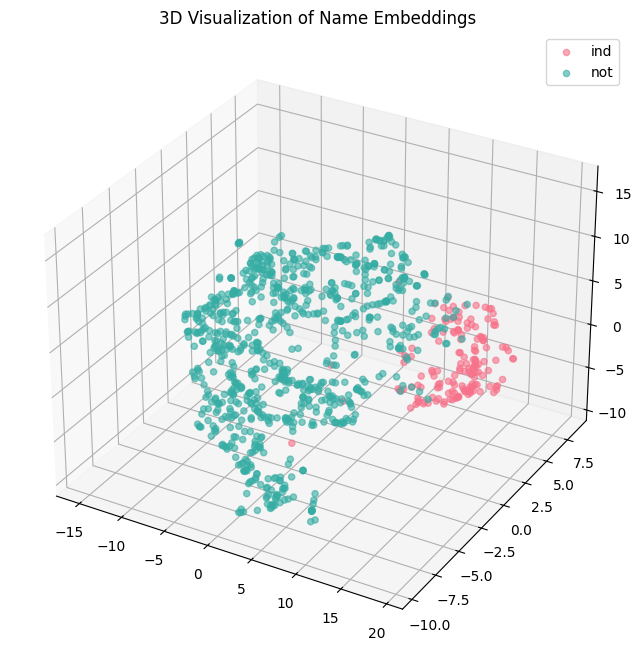

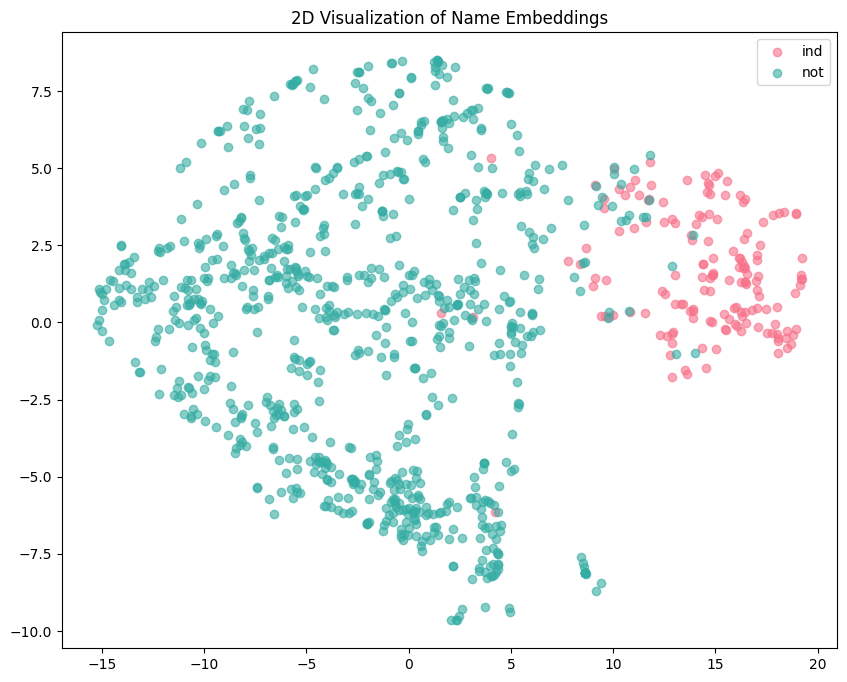

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2325 (\N{

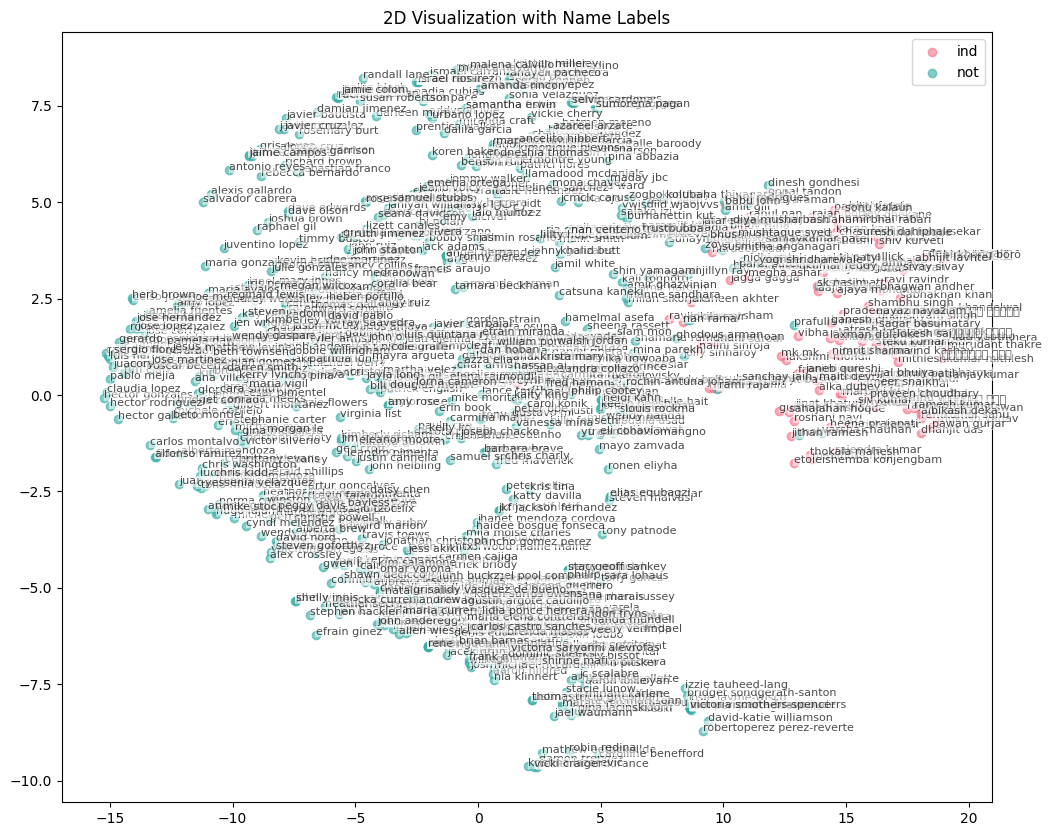

In [31]:
X_train, X_test, y_train, y_test, weights = process_data(df_combined)

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


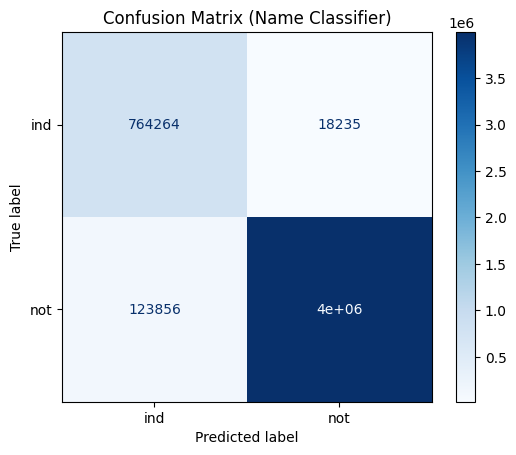


Name Classifier
Accuracy: 0.9710018367346939
Precision: 0.8605413682835653
Recall: 0.9766964558421161
F1: 0.9149470944601971


In [41]:
model = name_classifier(df_combined, X_train, X_test, y_train, y_test, weights)

In [42]:
y_probs = model.predict_proba(X_test)[:, 1]
y_probs

array([0.2644477 , 0.97511021, 0.99231834, ..., 0.99234247, 0.98150354,
       0.99490403])

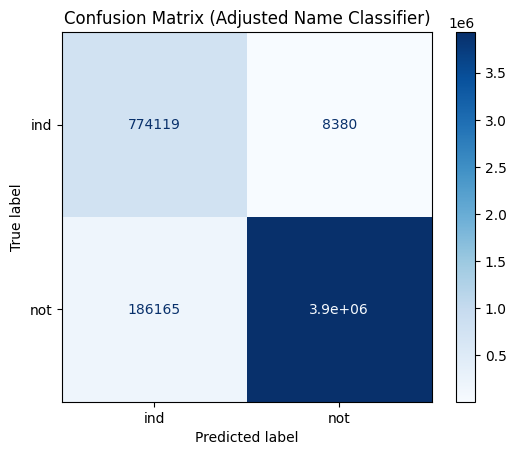


Adjusted Name Classifier
Accuracy: 0.9602969387755103
Precision: 0.806135476588176
Recall: 0.9892907211383017
F1: 0.888371070867687


In [45]:
y_pred_adjusted = (y_probs <= 0.85).astype(int)
calculate_stats(y_test, np.where(y_pred_adjusted == 1, "ind", "not"), "Adjusted Name Classifier", sorted(df["ethnic"].unique()))

In [46]:
with open('./models/remy_name_classifier.pkl', 'wb') as file:
    pickle.dump(model, file)

In [27]:
ec = EthnicClassifier.load_pretrained_model()
ec.classify_names(['Yūta Nakayama','Marcel Halstenberg','Raphaël Varane'])

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


['jap', 'ger', 'frn']

In [28]:
name_list = df["name"].to_list()
ethnic_list = ec.classify_names(name_list)
pd.Series(ethnic_list).value_counts()

eng    40868
ger    27870
ita    17415
jap    17336
ind    12664
frn    10148
spa     8843
rus     6516
chi     3432
mea     2028
kor      888
vie      267
Name: count, dtype: int64

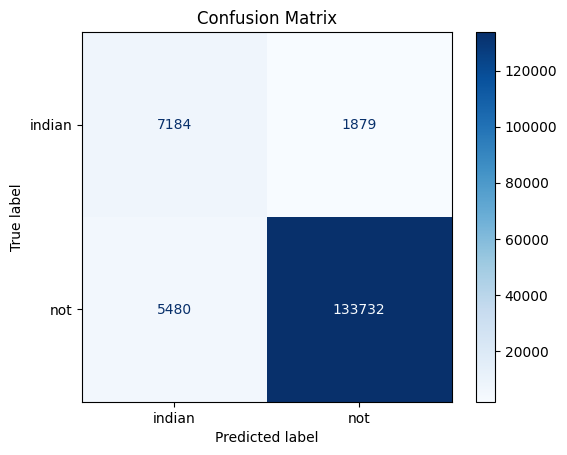

Accuracy: 0.9503692463328275
Precision: 0.9605418283591677
Recall: 0.9503692463328275
F1: 0.9541569538595618


In [29]:
results_test = df["ethnic"]
results_pred = pd.Series(ethnic_list).apply(lambda x: "ind" if x == "ind" else "not")

cm = confusion_matrix(results_test, results_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["indian", "not"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix')
plt.show()

accuracy = accuracy_score(results_test, results_pred)
precision = precision_score(results_test, results_pred, average='weighted')
recall = recall_score(results_test, results_pred, average='weighted')
f1 = f1_score(results_test, results_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)